# 🛡️ Phishing Email Detection - DistilBERT Fine-tuning

**Project:** Hybrid AI Defense - Closing the Detection Gap Against AI-Generated Phishing  
**Author:** Ramkumar  
**Model:** DistilBERT (HuggingFace Transformers)  
**Framework:** PyTorch

---

## 1. Setup & Installation

In [1]:
# Install required libraries
!pip install transformers datasets torch scikit-learn pandas numpy accelerate -q

In [2]:
# Check GPU availability
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4


## 2. Upload Data

Upload your processed CSV files from `data/processed/`:
- `train.csv`
- `validation.csv`
- `test.csv`

In [3]:
# Upload files (for Google Colab)
from google.colab import files
uploaded = files.upload()

Saving test.csv to test.csv
Saving train.csv to train.csv
Saving validation.csv to validation.csv


In [4]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Load data
train_df = pd.read_csv('train.csv')
val_df = pd.read_csv('validation.csv')
test_df = pd.read_csv('test.csv')

print(f"Train: {len(train_df)} samples")
print(f"Validation: {len(val_df)} samples")
print(f"Test: {len(test_df)} samples")
print(f"\nLabel distribution (train):")
print(train_df['label'].value_counts())

Train: 4655 samples
Validation: 582 samples
Test: 582 samples

Label distribution (train):
label
0    2391
1    2264
Name: count, dtype: int64


## 3. Prepare Dataset for Transformers

In [5]:
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer

# Load DistilBERT tokenizer
MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Convert pandas to HuggingFace Dataset
train_dataset = Dataset.from_pandas(train_df[['text', 'label']])
val_dataset = Dataset.from_pandas(val_df[['text', 'label']])
test_dataset = Dataset.from_pandas(test_df[['text', 'label']])

dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

print(dataset)

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 4655
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 582
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 582
    })
})


In [6]:
# Tokenization function
def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=512  # DistilBERT max length
    )

# Tokenize all datasets
tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Remove text column (not needed for training)
tokenized_dataset = tokenized_dataset.remove_columns(['text'])

# Rename label to labels (required by Trainer)
tokenized_dataset = tokenized_dataset.rename_column('label', 'labels')

# Set format for PyTorch
tokenized_dataset.set_format('torch')

print("Tokenization complete!")
print(tokenized_dataset)

Map:   0%|          | 0/4655 [00:00<?, ? examples/s]

Map:   0%|          | 0/582 [00:00<?, ? examples/s]

Map:   0%|          | 0/582 [00:00<?, ? examples/s]

Tokenization complete!
DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4655
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 582
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 582
    })
})


## 4. Load DistilBERT Model

In [7]:
from transformers import AutoModelForSequenceClassification

# Load pre-trained DistilBERT for binary classification
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,  # Binary: 0=Legit, 1=Phishing
    id2label={0: "LEGITIMATE", 1: "PHISHING"},
    label2id={"LEGITIMATE": 0, "PHISHING": 1}
)

print(f"Model loaded: {MODEL_NAME}")
print(f"Parameters: {model.num_parameters():,}")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_transform.weight  | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
classifier.bias         | MISSING    | 
classifier.weight       | MISSING    | 
pre_classifier.weight   | MISSING    | 
pre_classifier.bias     | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Model loaded: distilbert-base-uncased
Parameters: 66,955,010


## 5. Training Configuration

In [8]:
from transformers import TrainingArguments, Trainer

# Define metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='binary'
    )

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    logging_dir='./logs',
    logging_steps=50,
    report_to='none',  # Disable wandb
    seed=42
)

print("Training configuration set!")

`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.


Training configuration set!


In [9]:
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
    compute_metrics=compute_metrics
)

print("Trainer initialized!")

Trainer initialized!


## 6. Train the Model 🚀

In [10]:
# Start training
print("Starting training...")
print("="*50)

trainer.train()

print("="*50)
print("Training complete!")

Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.113645,0.081133,0.975945,0.982079,0.968198,0.975089
2,0.066525,0.066180,0.981100,0.992754,0.968198,0.980322
3,0.033287,0.084308,0.977663,0.992701,0.961131,0.976661


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].


Training complete!


## 7. Evaluate on Test Set

In [11]:
# Evaluate on test set
print("Evaluating on test set...")
results = trainer.evaluate(tokenized_dataset['test'])

print("\n" + "="*50)
print("TEST RESULTS")
print("="*50)
print(f"Accuracy:  {results['eval_accuracy']:.4f}")
print(f"Precision: {results['eval_precision']:.4f}")
print(f"Recall:    {results['eval_recall']:.4f}")
print(f"F1 Score:  {results['eval_f1']:.4f}")

Evaluating on test set...



TEST RESULTS
Accuracy:  0.9863
Precision: 0.9893
Recall:    0.9823
F1 Score:  0.9858


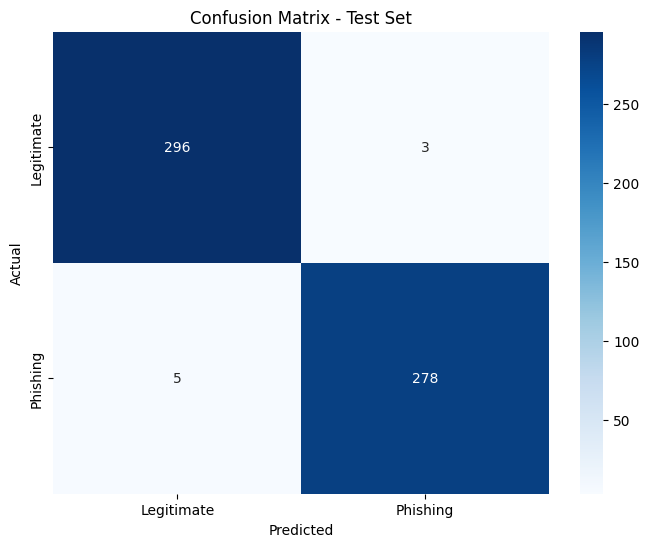


True Negatives (Legit→Legit): 296
False Positives (Legit→Phishing): 3
False Negatives (Phishing→Legit): 5
True Positives (Phishing→Phishing): 278


In [12]:
# Detailed predictions and confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions
predictions = trainer.predict(tokenized_dataset['test'])
preds = np.argmax(predictions.predictions, axis=-1)
labels = predictions.label_ids

# Confusion Matrix
cm = confusion_matrix(labels, preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legitimate', 'Phishing'],
            yticklabels=['Legitimate', 'Phishing'])
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(f"\nTrue Negatives (Legit→Legit): {cm[0][0]}")
print(f"False Positives (Legit→Phishing): {cm[0][1]}")
print(f"False Negatives (Phishing→Legit): {cm[1][0]}")
print(f"True Positives (Phishing→Phishing): {cm[1][1]}")

## 8. Analyze Human vs LLM Detection

In [13]:
# Analyze by source (human vs LLM)
test_df_with_preds = test_df.copy()
test_df_with_preds['predicted'] = preds
test_df_with_preds['correct'] = test_df_with_preds['label'] == test_df_with_preds['predicted']

print("="*50)
print("ACCURACY BY SOURCE")
print("="*50)

for source in ['human', 'llm']:
    source_df = test_df_with_preds[test_df_with_preds['source'] == source]
    accuracy = source_df['correct'].mean()
    print(f"{source.upper()}-generated emails: {accuracy:.4f} ({len(source_df)} samples)")

print("\n" + "="*50)
print("ACCURACY BY SOURCE x TYPE")
print("="*50)

for source in ['human', 'llm']:
    for label in [0, 1]:
        subset = test_df_with_preds[(test_df_with_preds['source'] == source) &
                                     (test_df_with_preds['label'] == label)]
        if len(subset) > 0:
            accuracy = subset['correct'].mean()
            label_name = 'Legit' if label == 0 else 'Phishing'
            print(f"{source.upper()} {label_name}: {accuracy:.4f} ({len(subset)} samples)")

ACCURACY BY SOURCE
HUMAN-generated emails: 0.9333 (45 samples)
LLM-generated emails: 1.0000 (203 samples)

ACCURACY BY SOURCE x TYPE
HUMAN Phishing: 0.9333 (45 samples)
LLM Legit: 1.0000 (102 samples)
LLM Phishing: 1.0000 (101 samples)


## 9. Save the Model

In [14]:
# Save model and tokenizer
MODEL_SAVE_PATH = './phishing_detector_model_v1'

trainer.save_model(MODEL_SAVE_PATH)
tokenizer.save_pretrained(MODEL_SAVE_PATH)

print(f"Model saved to: {MODEL_SAVE_PATH}")

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Model saved to: ./phishing_detector_model


In [15]:
# Download model (for Colab)
!zip -r phishing_detector_model.zip phishing_detector_model/
files.download('phishing_detector_model.zip')

  adding: phishing_detector_model/ (stored 0%)
  adding: phishing_detector_model/config.json (deflated 50%)
  adding: phishing_detector_model/model.safetensors (deflated 8%)
  adding: phishing_detector_model/tokenizer_config.json (deflated 42%)
  adding: phishing_detector_model/training_args.bin (deflated 53%)
  adding: phishing_detector_model/tokenizer.json (deflated 71%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 10. Test with Sample Email

In [16]:
# Quick test function
def predict_email(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=-1)
        prediction = torch.argmax(probs, dim=-1).item()

    label = 'PHISHING ⚠️' if prediction == 1 else 'LEGITIMATE ✅'
    confidence = probs[0][prediction].item() * 100

    print(f"Prediction: {label}")
    print(f"Confidence: {confidence:.2f}%")
    return prediction, confidence

# Test examples
print("="*50)
print("TEST 1: Phishing-like email")
print("="*50)
predict_email("URGENT: Your account has been compromised! Click here immediately to verify your identity or your account will be suspended. [URL]")

print("\n" + "="*50)
print("TEST 2: Legitimate-like email")
print("="*50)
predict_email("Hi team, just a reminder that our weekly meeting is scheduled for tomorrow at 3 PM. Please review the attached agenda beforehand.")

TEST 1: Phishing-like email
Prediction: PHISHING ⚠️
Confidence: 99.74%

TEST 2: Legitimate-like email
Prediction: LEGITIMATE ✅
Confidence: 99.04%


(0, 99.03842210769653)

---
## ✅ Training Complete!

**Next Steps:**
1. Download the saved model (`phishing_detector_model.zip`)
2. Extract to `model/saved_models/` in your project
3. Proceed to Week 2: Backend & URL Analysis

In [17]:
# ============================================================
# 11. Better Test Examples & Visualizations
# ============================================================

# --- TEST 1: Phishing Email (Similar to Training Data) ---
print("="*50)
print("TEST 1: Phishing-like email (realistic)")
print("="*50)
phishing_text = """Dear Customer,

We have detected unusual activity on your account. Your account access has been temporarily limited.
To restore full access, please verify your identity immediately by clicking the link below.

[URL]

If you do not verify within 24 hours, your account will be permanently suspended.
Please do not reply to this email.

Sincerely,
Security Team"""
predict_email(phishing_text)

# --- TEST 2: Legitimate Email (Similar to Training Data) ---
print("\n" + "="*50)
print("TEST 2: Legitimate email (realistic)")
print("="*50)
legit_text = """Hi John,

I hope this email finds you well. I wanted to follow up on our discussion from last week about the quarterly report.

The numbers look good and I've attached the updated spreadsheet with the latest figures.
Let me know if you have any questions or need any clarifications.

Best regards,
Sarah
Marketing Department"""
predict_email(legit_text)

# --- TEST 3: More legitimate examples ---
print("\n" + "="*50)
print("TEST 3: Internal work email")
print("="*50)
legit_text2 = """Team,

Quick reminder that the office will be closed next Monday for the holiday.
Please make sure to complete your timesheet by Friday.

Thanks,
HR Team"""
predict_email(legit_text2)

print("\n" + "="*50)
print("TEST 4: LLM-style phishing")
print("="*50)
phishing_text2 = """Dear Valued Customer,

We regret to inform you that your payment method on file has been declined.
To avoid service interruption, please update your billing information immediately.

Click here to update your account: [URL]

This is an automated message. Failure to respond may result in account termination.

Thank you for your cooperation.
Customer Support Team"""
predict_email(phishing_text2)

TEST 1: Phishing-like email (realistic)
Prediction: PHISHING ⚠️
Confidence: 99.75%

TEST 2: Legitimate email (realistic)
Prediction: LEGITIMATE ✅
Confidence: 99.63%

TEST 3: Internal work email
Prediction: LEGITIMATE ✅
Confidence: 96.56%

TEST 4: LLM-style phishing
Prediction: PHISHING ⚠️
Confidence: 99.75%


(1, 99.7539758682251)

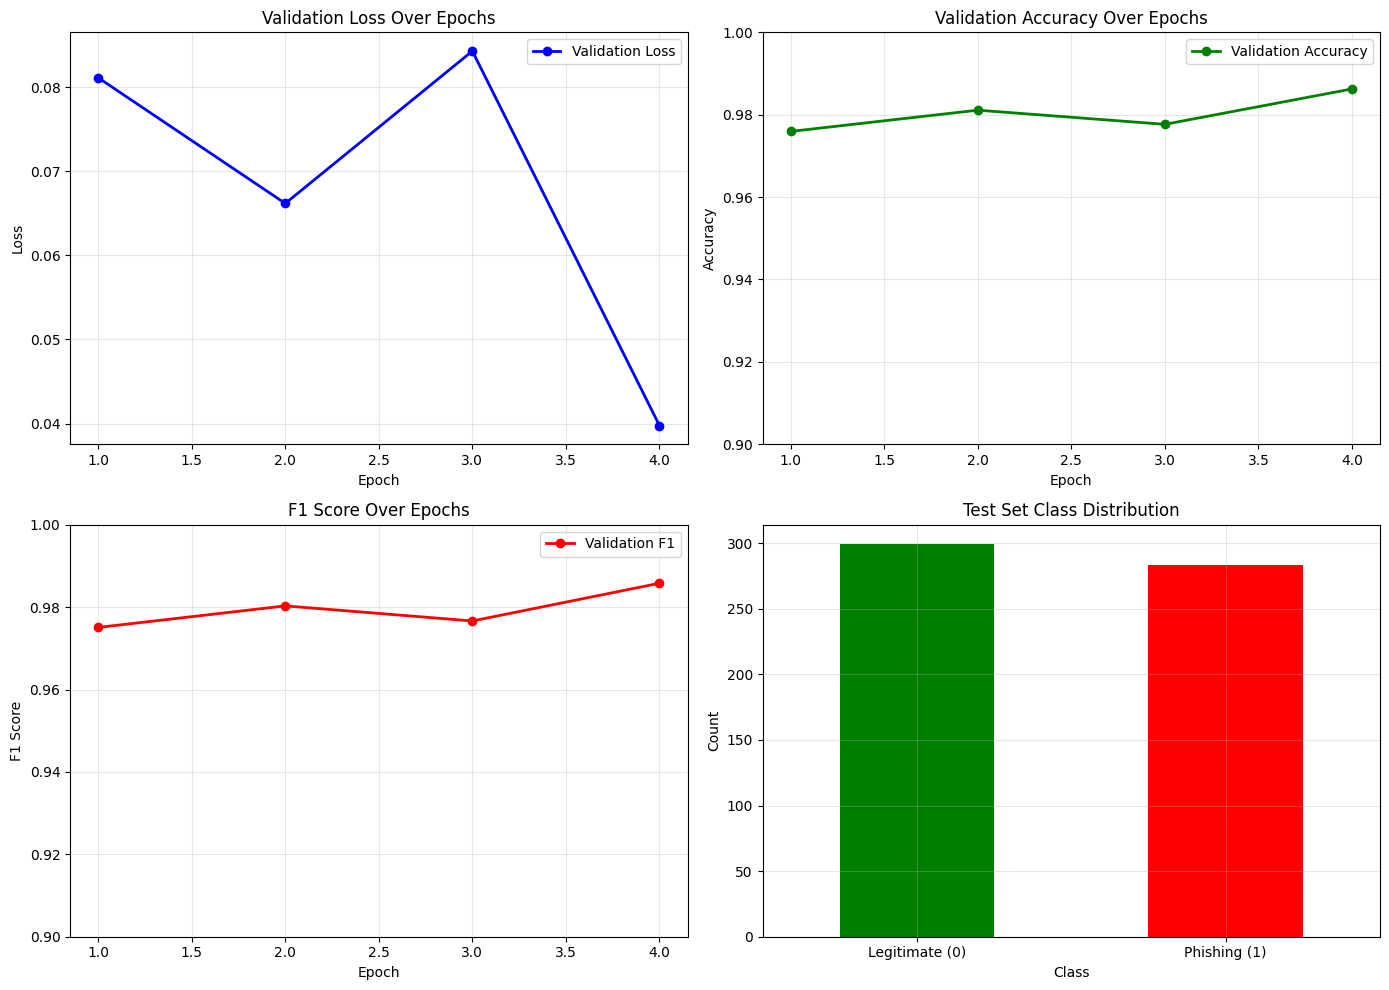


📊 FINAL MODEL METRICS SUMMARY
   Metric           Value
 Accuracy 0.9863 (98.63%)
Precision 0.9893 (98.93%)
   Recall 0.9823 (98.23%)
 F1 Score 0.9858 (98.58%)


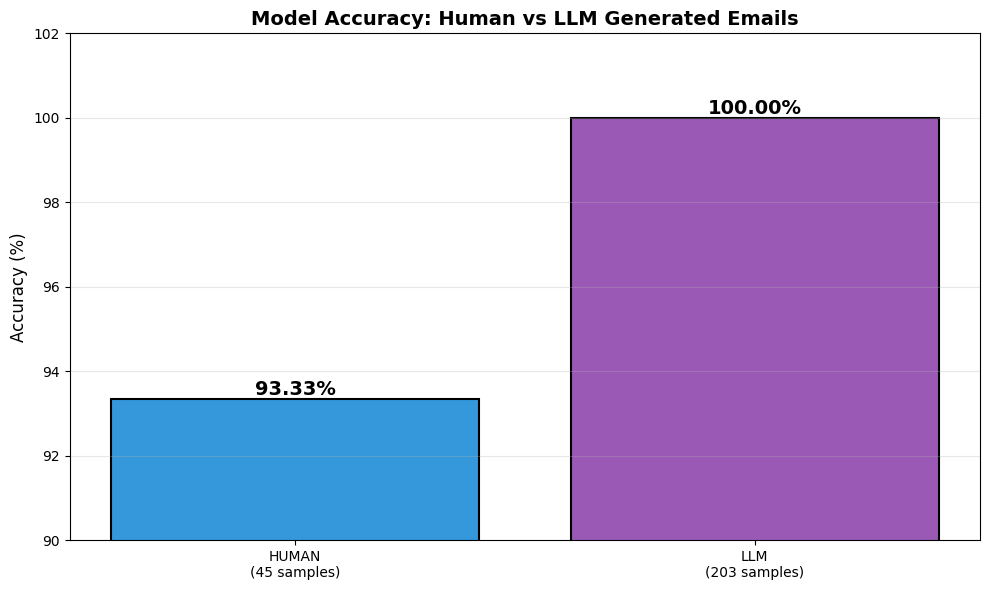


✅ Graphs saved as 'training_metrics.png' and 'accuracy_by_source.png'


In [18]:
# ============================================================
# 12. Training Visualizations & Metrics
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- 1. Training History Plot ---
# Get training history from trainer
history = trainer.state.log_history

# Extract metrics
train_loss = [x['loss'] for x in history if 'loss' in x]
eval_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]
eval_accuracy = [x['eval_accuracy'] for x in history if 'eval_accuracy' in x]
eval_f1 = [x['eval_f1'] for x in history if 'eval_f1' in x]
epochs = list(range(1, len(eval_loss) + 1))

# Create subplot figure
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Training vs Validation Loss
ax1 = axes[0, 0]
ax1.plot(epochs, eval_loss, 'b-o', label='Validation Loss', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Validation Loss Over Epochs')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Accuracy Over Epochs
ax2 = axes[0, 1]
ax2.plot(epochs, eval_accuracy, 'g-o', label='Validation Accuracy', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Validation Accuracy Over Epochs')
ax2.set_ylim([0.9, 1.0])
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: F1 Score Over Epochs
ax3 = axes[1, 0]
ax3.plot(epochs, eval_f1, 'r-o', label='Validation F1', linewidth=2)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1 Score')
ax3.set_title('F1 Score Over Epochs')
ax3.set_ylim([0.9, 1.0])
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Class Distribution in Test Set
ax4 = axes[1, 1]
test_df['label'].value_counts().plot(kind='bar', ax=ax4, color=['green', 'red'])
ax4.set_xlabel('Class')
ax4.set_ylabel('Count')
ax4.set_title('Test Set Class Distribution')
ax4.set_xticklabels(['Legitimate (0)', 'Phishing (1)'], rotation=0)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

# --- 2. Metrics Summary Table ---
print("\n" + "="*60)
print("📊 FINAL MODEL METRICS SUMMARY")
print("="*60)

final_metrics = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Value': [
        f"{results['eval_accuracy']:.4f} ({results['eval_accuracy']*100:.2f}%)",
        f"{results['eval_precision']:.4f} ({results['eval_precision']*100:.2f}%)",
        f"{results['eval_recall']:.4f} ({results['eval_recall']*100:.2f}%)",
        f"{results['eval_f1']:.4f} ({results['eval_f1']*100:.2f}%)"
    ]
}
print(pd.DataFrame(final_metrics).to_string(index=False))

# --- 3. Accuracy by Source Bar Chart ---
fig, ax = plt.subplots(figsize=(10, 6))

source_accuracy = []
source_names = []
for source in ['human', 'llm']:
    source_df = test_df_with_preds[test_df_with_preds['source'] == source]
    accuracy = source_df['correct'].mean()
    source_accuracy.append(accuracy * 100)
    source_names.append(f"{source.upper()}\n({len(source_df)} samples)")

colors = ['#3498db', '#9b59b6']
bars = ax.bar(source_names, source_accuracy, color=colors, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar, acc in zip(bars, source_accuracy):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.2f}%', ha='center', va='bottom', fontweight='bold', fontsize=14)

ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('Model Accuracy: Human vs LLM Generated Emails', fontsize=14, fontweight='bold')
ax.set_ylim([90, 102])
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('accuracy_by_source.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Graphs saved as 'training_metrics.png' and 'accuracy_by_source.png'")

In [19]:
# Test with actual samples from test.csv
print("="*60)
print("TESTING WITH ACTUAL SAMPLES FROM TEST SET")
print("="*60)

# Get random samples
np.random.seed(42)
legit_samples = test_df[test_df['label'] == 0].sample(3)
phishing_samples = test_df[test_df['label'] == 1].sample(3)

print("\n--- LEGITIMATE EMAILS (should predict LEGITIMATE) ---\n")
for idx, row in legit_samples.iterrows():
    print(f"Source: {row['source']}, Text preview: {row['text'][:100]}...")
    pred, conf = predict_email(row['text'])
    print(f"Result: {'✅ CORRECT' if pred == 0 else '❌ WRONG'}\n")

print("\n--- PHISHING EMAILS (should predict PHISHING) ---\n")
for idx, row in phishing_samples.iterrows():
    print(f"Source: {row['source']}, Text preview: {row['text'][:100]}...")
    pred, conf = predict_email(row['text'])
    print(f"Result: {'✅ CORRECT' if pred == 1 else '❌ WRONG'}\n")

TESTING WITH ACTUAL SAMPLES FROM TEST SET

--- LEGITIMATE EMAILS (should predict LEGITIMATE) ---

Source: enron, Text preview: seeking for financial investment information johannesburg 21 gauteg province rep . of south africa e...
Prediction: LEGITIMATE ✅
Confidence: 68.80%
Result: ✅ CORRECT

Source: enron, Text preview: spot deals - april , 2001 the following have been entered as spot deals for april , 2001 : deal # co...
Prediction: LEGITIMATE ✅
Confidence: 99.85%
Result: ✅ CORRECT

Source: llm, Text preview: Dear Ms. Jessica Davis, I hope this message finds you well. We are reaching out to remind you of the...
Prediction: LEGITIMATE ✅
Confidence: 99.85%
Result: ✅ CORRECT


--- PHISHING EMAILS (should predict PHISHING) ---

Source: llm, Text preview: Dear David Miller, This is an urgent message regarding COVID-19 contact tracing. Our records indicat...
Prediction: PHISHING ⚠️
Confidence: 99.69%
Result: ✅ CORRECT

Source: llm, Text preview: Dear Olivia, I hope this email finds you wit